In [1]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from adspy_shared_utilities import plot_class_regions_for_classifier_subplot
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from adspy_shared_utilities import plot_decision_tree
from adspy_shared_utilities import plot_class_regions_for_classifier
from adspy_shared_utilities import plot_decision_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from adspy_shared_utilities import plot_decision_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import ExtraTreesClassifier
import pickle
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.neural_network import MLPClassifier
from finta import TA
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.callbacks import EarlyStopping
import glob
import os

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
print(os.getcwd())


G:\My Drive\Education\MAD\Winter 2020 program\31. CAPSTONE\Final Submission


In [4]:
os.chdir("G:\\My Drive\\Education\\MAD\\Winter 2020 program\\31. CAPSTONE\\Final Submission")
# files = os.path.join("*.csv")


In [5]:
print(os.getcwd())


G:\My Drive\Education\MAD\Winter 2020 program\31. CAPSTONE\Final Submission


In [4]:
INDICATORS = ['RSI', 'MACD', 'STOCH','ADL', 'ATR', 'MOM', 'MFI', 'ROC', 'OBV', 'CCI', 'EMV', 'VORTEX']
Df_hourly_merge = pd.read_csv('assets/MergeJMJPCHourly2019202_NewsGoogleApi_ActualLabel.csv')

def _exponential_smooth(data, alpha):
    """
    Function that exponentially smooths dataset so values are less 'rigid'
    :param alpha: weight factor to weight recent values more
    """
    
    return data.ewm(alpha=alpha).mean()

Indicatordata = _exponential_smooth(Df_hourly_merge[['Close', 'Open','High','Low','Volume']], 0.65)
def _get_indicator_data(data):
    """
    Function that uses the finta API to calculate technical indicators used as the features
    :return:
    """

    for indicator in INDICATORS:
        ind_data = eval('TA.' + indicator + '(data)')
        if not isinstance(ind_data, pd.DataFrame):
            ind_data = ind_data.to_frame()
        data = data.merge(ind_data, left_index=True, right_index=True)
    data.rename(columns={"14 period EMV.": '14 period EMV'}, inplace=True)

    # Also calculate moving averages for features
    data['ema50'] = data['Close'] / data['Close'].ewm(50).mean()
    data['ema21'] = data['Close'] / data['Close'].ewm(21).mean()
    data['ema15'] = data['Close'] / data['Close'].ewm(14).mean()
    data['ema5'] = data['Close'] / data['Close'].ewm(5).mean()

    # Instead of using the actual volume value (which changes over time), we normalize it with a moving volume average
    data['normVol'] = data['Volume'] / data['Volume'].ewm(5).mean()

#     # Remove columns that won't be used as features
#     del (data['open'])
#     del (data['high'])
#     del (data['low'])
#     del (data['volume'])
#     del (data['Adj Close'])
    
    return data

Indicatordatafinal = _get_indicator_data(Indicatordata)

Indicatordatafinal = Indicatordatafinal.drop(['Close', 'Open', 'High', 'Low', 'Volume'], axis = 1)
Df_hourly_merge2 = pd.merge(Df_hourly_merge, Indicatordatafinal, left_index=True, right_index=True)

Df_hourly_merge2 = Df_hourly_merge2.drop(['time','hour','Open Time','_merge','Signal','Position', 'Signal35JMJ', 'Position35JMJ', 'Ignore'], axis = 1)




def binary(value):
  if value > 0:
    return 1
  else:
    return 0

columns = ['favorites', 'retweets', 'number_of_followers', 'following',
           'followers_following_ratio', '2x_retweets_+_favorites', 'polarity',
           'W1 Score', 'Bull_ratio', 'W Score With Bull Ratio', 'Open', 'High',
           'Low', 'Close', 'Volume', 'Quote Asset Volume', 'Number of Trades',
           'TB Base Volume', 'TB Quote Volume', '3MovingAverage', '5MovingAverage',
           'JMJ_3HMoving_averages', 'JMJ_5HMoving_averages', 
           '14 period RSI', 'MACD', 'SIGNAL', '14 period STOCH %K', 'MFV',
           '14 period ATR', 'MOM', '14 period MFI', 'ROC', 'OBV', '20 period CCI',
           '14 period EMV', 'VIm', 'VIp', 'ema50', 'ema21', 'ema15', 'ema5']


for column in columns: 
    Df_hourly_merge2['Binary{}'.format(column)]  = (Df_hourly_merge2[column]- Df_hourly_merge2[column].shift(1) ).apply(binary)
    

In [5]:
Df_hourly_merge2.columns.values

array(['favorites', 'retweets', 'number_of_followers', 'following',
       'followers_following_ratio', '2x_retweets_+_favorites', 'polarity',
       'W1 Score', 'Bull_ratio', 'W Score With Bull Ratio', 'Open',
       'High', 'Low', 'Close', 'Volume', 'Quote Asset Volume',
       'Number of Trades', 'TB Base Volume', 'TB Quote Volume',
       '3MovingAverage', '5MovingAverage', 'JMJ_3HMoving_averages',
       'JMJ_5HMoving_averages', 'Actual_Label',
       'Bitcoin_Google_Trend_Score', 'BTC_Google_Trend_Score',
       'Mkt Sentiment', 'Crypto Sentiment',
       'Historically Optimal SMA(s-t)', 'Historically Optimal SMA(l-t)',
       'Historically Optimal WMA(s-t)', 'Historically Optimal WMA(l-t)',
       'Historically Optimal EMA(s-t)', 'Historically Optimal EMA(l-t)',
       'Twitter Hourly Favorites SMA(s-t)',
       'Twitter Hourly Favorites SMA(l-t)',
       'Twitter Hourly Favorites WMA(s-t)',
       'Twitter Hourly Favorites WMA(l-t)',
       'Twitter Hourly Favorites EMA(s-t)',


In [6]:
Df_hourly_merge2 = Df_hourly_merge2[[
    '# of Hourly Trades SMA(l-t)',
    '# of Hourly Trades SMA(s-t)',
    '# of Hourly Trades WMA(l-t)',
    '14 period MFI',
    '14 period STOCH %K',
    '20 period CCI',
    '2x_retweets_+_favorites',
    '3MovingAverage',
    'BinaryJMJ_3HMoving_averages',
    'BinaryJMJ_5HMoving_averages',
    'BinaryMFV',
    'BinaryOpen',
    'BinaryQuote Asset Volume',
    'BinaryVolume',
    'Bitcoin_Google_Trend_Score',
    'BTC_Google_Trend_Score',
    'Bull_ratio',
    'ema5',
    'ema50',
    'favorites',
    'followers_following_ratio',
    'following',
    'Historically Optimal EMA(l-t)',
    'Historically Optimal SMA(s-t)',
    'Historically Optimal WMA(s-t)',
    'MFV',
    'Mkt Sentiment',
    'normVol',
    'Number of Trades',
    'Close',
    'OBV',
    'polarity',
    'Quote Asset Volume',
    'Quote Asset Volume SMA(l-t)',
    'Quote Asset Volume SMA(s-t)',
    'retweets',
    'ROC',
    'TB Base Volume',
    'TB Base Volume EMA(l-t)',
    'TB Base Volume EMA(s-t)',
    'TB Base Volume SMA(l-t)',
    'TB Base Volume WMA(l-t)',
    'TB Base Volume WMA(s-t)',
    'TB Quote Volume',
    'TB Quote Volume WMA(s-t)',
    'Twitter Hourly 2x Retweets + Favorites EMA(s-t)',
    'Twitter Hourly 2x Retweets + Favorites SMA(s-t)',
    'Twitter Hourly Bull Ratio EMA(s-t)',
    'Twitter Hourly Bull Ratio SMA(l-t)',
    'Twitter Hourly Bull Ratio SMA(s-t)',
    'Twitter Hourly Bull Ratio WMA(l-t)',
    'Twitter Hourly Bull Ratio WMA(s-t)',
    'Twitter Hourly Favorites EMA(s-t)',
    'Twitter Hourly Favorites WMA(l-t)',
    'Twitter Hourly Favorites WMA(s-t)',
    'Twitter Hourly Follower Exposure EMA(l-t)',
    'Twitter Hourly Follower Exposure EMA(s-t)',
    'Twitter Hourly Follower Exposure SMA(s-t)',
    'Twitter Hourly Follower Exposure WMA(l-t)' ,
    'Twitter Hourly Follower Exposure WMA(s-t)',
    'Twitter Hourly Following Exposure EMA(l-t)',
    'Twitter Hourly Following Exposure SMA(s-t)',
    'Twitter Hourly Following Exposure WMA(s-t)',
    'Twitter Hourly Polarity Score EMA(l-t)',
    'Twitter Hourly Polarity Score EMA(s-t)',
    'Twitter Hourly Polarity Score SMA(l-t)',
    'Twitter Hourly Polarity Score SMA(s-t)',
    'Twitter Hourly Polarity Score WMA(l-t)',
    'Twitter Hourly Polarity Score WMA(s-t)',
    'Twitter Hourly Retweets EMA(l-t)',
    'Twitter Hourly Retweets SMA(l-t)',
    'Twitter Hourly Retweets SMA(s-t)',
    'Twitter Hourly Retweets WMA(s-t)',
    'Twitter Hourly Weighted Bull Ratio EMA(l-t)',
    'Twitter Hourly Weighted Bull Ratio EMA(s-t)',
    'Twitter Hourly Weighted Bull Ratio SMA(l-t)',
    'Twitter Hourly Weighted Bull Ratio SMA(s-t)',
    'Twitter Hourly Weighted Bull Ratio WMA(l-t)',
    'Twitter Hourly Weighted Bull Ratio WMA(s-t)',
    'Twitter W1 Score EMA(l-t)',
    'Twitter W1 Score EMA(s-t)',
    'Twitter W1 Score SMA(l-t)',
    'Twitter W1 Score SMA(s-t)',
    'Twitter W1 Score WMA(l-t)',
    'Twitter W1 Score WMA(s-t)',
    'VIm',
    'Volume',
    'W1 Score','Actual_Label']]
Df_hourly_merge2

,# of Hourly Trades SMA(l-t),# of Hourly Trades SMA(s-t),# of Hourly Trades WMA(l-t),14 period MFI,14 period STOCH %K,20 period CCI,2x_retweets_+_favorites,3MovingAverage,BinaryJMJ_3HMoving_averages,BinaryJMJ_5HMoving_averages,...,Twitter W1 Score EMA(l-t),Twitter W1 Score EMA(s-t),Twitter W1 Score SMA(l-t),Twitter W1 Score SMA(s-t),Twitter W1 Score WMA(l-t),Twitter W1 Score WMA(s-t),VIm,Volume,W1 Score,Actual_Label
0,9817.952381,9893.000000,8855.707755,NaN,NaN,NaN,9.071429,3841.766667,0,0,...,0.135012,0.148529,0.138148,0.193676,0.124304,0.162161,NaN,651.947136,0.264455,1.0
1,9772.047619,9187.000000,8772.238367,NaN,NaN,66.666667,3.644068,3833.403333,1,0,...,0.133712,0.145115,0.140709,0.190524,0.124006,0.160750,NaN,732.021603,0.097316,0.0
2,9631.714286,8814.727273,8726.655510,NaN,NaN,56.760056,3.478261,3837.086667,0,0,...,0.134074,0.145054,0.142410,0.188199,0.125651,0.162292,NaN,649.628917,0.144203,0.0
3,9341.238095,8855.000000,8746.358367,NaN,NaN,-122.072855,3.257985,3836.630000,0,0,...,0.133261,0.142749,0.146707,0.192741,0.125909,0.160724,NaN,1094.336108,0.110483,0.0
4,9224.000000,8726.818182,8668.191837,NaN,NaN,-112.657835,6.181818,3833.600000,0,0,...,0.135552,0.146546,0.154514,0.193507,0.129679,0.166031,NaN,774.978958,0.199699,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25498,69718.761905,84536.545455,67611.409796,53.079306,58.250023,71.659238,7.102381,57489.413333,1,0,...,0.155910,0.156923,0.158734,0.143910,0.160721,0.155244,0.925140,1454.499780,0.078660,0.0
25499,69809.571429,83459.000000,66804.516735,53.894526,49.058398,42.671500,3.797619,57773.616667,0,1,...,0.155194,0.155470,0.155921,0.148941,0.159539,0.153861,0.914098,1104.113290,0.135134,0.0
25500,69614.904762,83495.818182,66137.515102,49.643301,38.133394,11.025735,19.214286,57783.440000,0,1,...,0.153539,0.152253,0.153626,0.148890,0.157403,0.150181,0.920503,1452.775710,0.107210,1.0
25501,68090.857143,79858.181818,64948.639184,45.374998,37.990109,2.718952,28.111111,57376.063333,0,0,...,0.153935,0.153104,0.154047,0.153549,0.157550,0.151032,0.964061,723.321850,0.165014,0.0


In [7]:
Df_hourly_merge2.shape

(25503, 89)

In [8]:
Df_hourly_merge2

,# of Hourly Trades SMA(l-t),# of Hourly Trades SMA(s-t),# of Hourly Trades WMA(l-t),14 period MFI,14 period STOCH %K,20 period CCI,2x_retweets_+_favorites,3MovingAverage,BinaryJMJ_3HMoving_averages,BinaryJMJ_5HMoving_averages,...,Twitter W1 Score EMA(l-t),Twitter W1 Score EMA(s-t),Twitter W1 Score SMA(l-t),Twitter W1 Score SMA(s-t),Twitter W1 Score WMA(l-t),Twitter W1 Score WMA(s-t),VIm,Volume,W1 Score,Actual_Label
0,9817.952381,9893.000000,8855.707755,NaN,NaN,NaN,9.071429,3841.766667,0,0,...,0.135012,0.148529,0.138148,0.193676,0.124304,0.162161,NaN,651.947136,0.264455,1.0
1,9772.047619,9187.000000,8772.238367,NaN,NaN,66.666667,3.644068,3833.403333,1,0,...,0.133712,0.145115,0.140709,0.190524,0.124006,0.160750,NaN,732.021603,0.097316,0.0
2,9631.714286,8814.727273,8726.655510,NaN,NaN,56.760056,3.478261,3837.086667,0,0,...,0.134074,0.145054,0.142410,0.188199,0.125651,0.162292,NaN,649.628917,0.144203,0.0
3,9341.238095,8855.000000,8746.358367,NaN,NaN,-122.072855,3.257985,3836.630000,0,0,...,0.133261,0.142749,0.146707,0.192741,0.125909,0.160724,NaN,1094.336108,0.110483,0.0
4,9224.000000,8726.818182,8668.191837,NaN,NaN,-112.657835,6.181818,3833.600000,0,0,...,0.135552,0.146546,0.154514,0.193507,0.129679,0.166031,NaN,774.978958,0.199699,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25498,69718.761905,84536.545455,67611.409796,53.079306,58.250023,71.659238,7.102381,57489.413333,1,0,...,0.155910,0.156923,0.158734,0.143910,0.160721,0.155244,0.925140,1454.499780,0.078660,0.0
25499,69809.571429,83459.000000,66804.516735,53.894526,49.058398,42.671500,3.797619,57773.616667,0,1,...,0.155194,0.155470,0.155921,0.148941,0.159539,0.153861,0.914098,1104.113290,0.135134,0.0
25500,69614.904762,83495.818182,66137.515102,49.643301,38.133394,11.025735,19.214286,57783.440000,0,1,...,0.153539,0.152253,0.153626,0.148890,0.157403,0.150181,0.920503,1452.775710,0.107210,1.0
25501,68090.857143,79858.181818,64948.639184,45.374998,37.990109,2.718952,28.111111,57376.063333,0,0,...,0.153935,0.153104,0.154047,0.153549,0.157550,0.151032,0.964061,723.321850,0.165014,0.0


In [9]:
Df_hourly_merge2 =Df_hourly_merge2.dropna()

In [10]:
Df_hourly_merge2

,# of Hourly Trades SMA(l-t),# of Hourly Trades SMA(s-t),# of Hourly Trades WMA(l-t),14 period MFI,14 period STOCH %K,20 period CCI,2x_retweets_+_favorites,3MovingAverage,BinaryJMJ_3HMoving_averages,BinaryJMJ_5HMoving_averages,...,Twitter W1 Score EMA(l-t),Twitter W1 Score EMA(s-t),Twitter W1 Score SMA(l-t),Twitter W1 Score SMA(s-t),Twitter W1 Score WMA(l-t),Twitter W1 Score WMA(s-t),VIm,Volume,W1 Score,Actual_Label
14,8931.333333,8869.181818,9026.209796,35.260314,11.303420,-210.321723,3.408451,3806.920000,0,0,...,0.165914,0.192865,0.213798,0.232807,0.175054,0.218659,1.097094,3271.172140,0.140353,1.0
15,9020.095238,9300.454545,9106.512653,28.658180,13.118845,-232.602941,4.539801,3780.466667,0,0,...,0.171465,0.201799,0.221023,0.244369,0.182440,0.228286,1.176225,2025.998359,0.326886,1.0
16,8877.095238,9451.272727,9065.161633,24.094300,17.133088,-199.903715,3.941964,3764.386667,0,0,...,0.173669,0.204038,0.223042,0.253304,0.185982,0.230275,1.209041,1021.639250,0.235383,0.0
17,8766.761905,9255.181818,8999.296327,24.049405,18.174804,-166.392309,26.244009,3748.116667,1,0,...,0.183377,0.220782,0.232694,0.290063,0.198191,0.248970,1.200647,771.584632,0.455197,1.0
18,8507.714286,9117.545455,8950.968980,28.343189,34.023812,-112.802568,5.107843,3754.116667,1,0,...,0.183346,0.218228,0.233362,0.283758,0.199182,0.245473,1.146267,760.416581,0.182470,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25498,69718.761905,84536.545455,67611.409796,53.079306,58.250023,71.659238,7.102381,57489.413333,1,0,...,0.155910,0.156923,0.158734,0.143910,0.160721,0.155244,0.925140,1454.499780,0.078660,0.0
25499,69809.571429,83459.000000,66804.516735,53.894526,49.058398,42.671500,3.797619,57773.616667,0,1,...,0.155194,0.155470,0.155921,0.148941,0.159539,0.153861,0.914098,1104.113290,0.135134,0.0
25500,69614.904762,83495.818182,66137.515102,49.643301,38.133394,11.025735,19.214286,57783.440000,0,1,...,0.153539,0.152253,0.153626,0.148890,0.157403,0.150181,0.920503,1452.775710,0.107210,1.0
25501,68090.857143,79858.181818,64948.639184,45.374998,37.990109,2.718952,28.111111,57376.063333,0,0,...,0.153935,0.153104,0.154047,0.153549,0.157550,0.151032,0.964061,723.321850,0.165014,0.0


# Trying LTSM 

In [12]:
Df_hourly_merge2.columns.values

array(['# of Hourly Trades SMA(l-t)', '# of Hourly Trades SMA(s-t)',
       '# of Hourly Trades WMA(l-t)', '14 period MFI',
       '14 period STOCH %K', '20 period CCI', '2x_retweets_+_favorites',
       '3MovingAverage', 'BinaryJMJ_3HMoving_averages',
       'BinaryJMJ_5HMoving_averages', 'BinaryMFV', 'BinaryOpen',
       'BinaryQuote Asset Volume', 'BinaryVolume',
       'Bitcoin_Google_Trend_Score', 'BTC_Google_Trend_Score',
       'Bull_ratio', 'ema5', 'ema50', 'favorites',
       'followers_following_ratio', 'following',
       'Historically Optimal EMA(l-t)', 'Historically Optimal SMA(s-t)',
       'Historically Optimal WMA(s-t)', 'MFV', 'Mkt Sentiment', 'normVol',
       'Number of Trades', 'Close', 'OBV', 'polarity',
       'Quote Asset Volume', 'Quote Asset Volume SMA(l-t)',
       'Quote Asset Volume SMA(s-t)', 'retweets', 'ROC', 'TB Base Volume',
       'TB Base Volume EMA(l-t)', 'TB Base Volume EMA(s-t)',
       'TB Base Volume SMA(l-t)', 'TB Base Volume WMA(l-t)',
       '

In [13]:
Df_hourly_merge2.shape

(25489, 89)

In [17]:
%%time

Df_hourly_merge3= Df_hourly_merge2.copy()
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
# Df_hourly_merge3 = scaler.fit_transform(Df_hourly_merge3)
Df_hourly_merge3_without_label = Df_hourly_merge3.iloc[:, :-1] # Exclude the label column
scaler.fit(Df_hourly_merge3_without_label)
timesteps = 12
features =  88

# Create the input and output sequences
X = []
y = []

for i in range(timesteps, Df_hourly_merge3.shape[0]): 
    X.append(scaler.transform(Df_hourly_merge3.iloc[i-timesteps:i, :-1])) #All features except last column
    y.append(Df_hourly_merge3.iloc[i, -1]) #Label column
X, y = np.array(X), np.array(y)


# Reshape the data to match the input shape of the LSTM model
X = np.reshape(X, (X.shape[0], X.shape[1], features))


# Split the data using TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)

LTSM_RESULTS = []

for train_index, test_index in tscv.split(X):
    print(train_index, test_index)
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Define the model
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], features)))
    model.add(LSTM(128, return_sequences=True))
    # model.add(LSTM(100, return_sequences=True))
    model.add(LSTM(128,dropout = 0.1))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

#     #Early stop
    early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=10)

    # Fit the model to the training data
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=0, callbacks=[early_stop])

    # Make predictions
    y_pred = model.predict(X_test)
    testy_pred = (y_pred >= 0.5).astype(int)
    
    LTSMaccuracy = accuracy_score(y_test, testy_pred)
    LTSM_RESULTS.append(LTSMaccuracy)

    # Print classification report
    print(classification_report(y_test, testy_pred))
    print(confusion_matrix(y_test, testy_pred))

        
print('LTSM Accuracy = ' + str( sum(LTSM_RESULTS) / len(LTSM_RESULTS)))



[   0    1    2 ... 2314 2315 2316] [2317 2318 2319 ... 4630 4631 4632]
73/73 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

         0.0       0.50      0.28      0.36      1083
         1.0       0.54      0.75      0.63      1233

    accuracy                           0.53      2316
   macro avg       0.52      0.52      0.50      2316
weighted avg       0.52      0.53      0.50      2316

[[305 778]
 [307 926]]
[   0    1    2 ... 4630 4631 4632] [4633 4634 4635 ... 6946 6947 6948]
73/73 [==============================] - 2s 8ms/step
              precision    recall  f1-score   support

         0.0       0.52      0.52      0.52      1177
         1.0       0.51      0.51      0.51      1139

    accuracy                           0.52      2316
   macro avg       0.52      0.52      0.52      2316
weighted avg       0.52      0.52      0.52      2316

[[609 568]
 [553 586]]
[   0    1    2 ... 6946 6947 6948] [6949 6950 695

In [21]:
model

#### SAVE MODEL

In [21]:
#Save model

model.save('model/PriorityFeatures_100EPOCHSNews_Google_API_GPUTimeSeriesTweekThreshold_JT_OptimizedLSTM.h5')

#### LOAD MODEL

In [22]:
#Load Model
from tensorflow.keras.models import load_model

loaded_model = load_model('model/PriorityFeatures_100EPOCHSNews_Google_API_GPUTimeSeriesTweekThreshold_JT_OptimizedLSTM.h5')

# TESTING RESULTS

227/227 [==============================] - 2s 6ms/step
[[1501 2153]
 [1299 2304]]


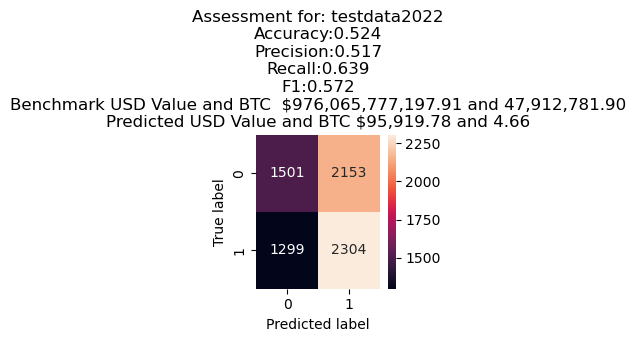

In [25]:
INDICATORS = ['RSI', 'MACD', 'STOCH','ADL', 'ATR', 'MOM', 'MFI', 'ROC', 'OBV', 'CCI', 'EMV', 'VORTEX']



testdata2022 ='assets/TEST_MergeJMJPCHourly2019202_NewsGoogleApi_ActualLabel.csv'


files= [testdata2022]

def _exponential_smooth(data, alpha):
    """
    Function that exponentially smooths dataset so values are less 'rigid'
    :param alpha: weight factor to weight recent values more
    """
    
    return data.ewm(alpha=alpha).mean()

def _get_indicator_data(data):
    """
    Function that uses the finta API to calculate technical indicators used as the features
    :return:
    """

    for indicator in INDICATORS:
        ind_data = eval('TA.' + indicator + '(data)')
        if not isinstance(ind_data, pd.DataFrame):
            ind_data = ind_data.to_frame()
        data = data.merge(ind_data, left_index=True, right_index=True)
    data.rename(columns={"14 period EMV.": '14 period EMV'}, inplace=True)

    # Also calculate moving averages for features
    data['ema50'] = data['Close'] / data['Close'].ewm(50).mean()
    data['ema21'] = data['Close'] / data['Close'].ewm(21).mean()
    data['ema15'] = data['Close'] / data['Close'].ewm(14).mean()
    data['ema5'] = data['Close'] / data['Close'].ewm(5).mean()

    # Instead of using the actual volume value (which changes over time), we normalize it with a moving volume average
    data['normVol'] = data['Volume'] / data['Volume'].ewm(5).mean()

    return data

UpperThreshold = 0.5
LowerThresshold = 0.5

for file,x in zip(files, ['testdata2022']):
    PredictDF= pd.read_csv(file)
#     prediction = (PredictDF.shift(-1)['Close'] >= PredictDF['Close'])
#     prediction = prediction.iloc[:-1]
#     PredictDF['Actual_Label'] = prediction.astype(int)
#     PredictDF= PredictDF.dropna()
    
    Indicatordata = _exponential_smooth(PredictDF[['Close', 'Open','High','Low','Volume']], 0.65)

    Indicatordatafinal = _get_indicator_data(Indicatordata)

    Indicatordatafinal = Indicatordatafinal.drop(['Close', 'Open', 'High', 'Low', 'Volume'], axis = 1)
    PredictDF = pd.merge(PredictDF, Indicatordatafinal, left_index=True, right_index=True)
    PredictDF = PredictDF.drop(['time','hour','Open Time','_merge','Signal','Position', 'Signal35JMJ', 'Position35JMJ', 'Ignore'], axis = 1)

    
    
    
    
    columns = ['favorites', 'retweets', 'number_of_followers', 'following',
           'followers_following_ratio', '2x_retweets_+_favorites', 'polarity',
           'W1 Score', 'Bull_ratio', 'W Score With Bull Ratio', 'Open', 'High',
           'Low', 'Close', 'Volume', 'Quote Asset Volume', 'Number of Trades',
           'TB Base Volume', 'TB Quote Volume', '3MovingAverage', '5MovingAverage',
           'JMJ_3HMoving_averages', 'JMJ_5HMoving_averages', 
           '14 period RSI', 'MACD', 'SIGNAL', '14 period STOCH %K', 'MFV',
           '14 period ATR', 'MOM', '14 period MFI', 'ROC', 'OBV', '20 period CCI',
           '14 period EMV', 'VIm', 'VIp', 'ema50', 'ema21', 'ema15', 'ema5']

    
    def binary(value):
        if value > 0:
            return 1
        else:
            return 0

    for column in columns: 
        PredictDF['Binary{}'.format(column)]  = (PredictDF[column] - PredictDF[column].shift(1)).apply(binary)
    

    PredictDF = PredictDF.dropna()

    PredictDF = PredictDF[[
    '# of Hourly Trades SMA(l-t)',
    '# of Hourly Trades SMA(s-t)',
    '# of Hourly Trades WMA(l-t)',
    '14 period MFI',
    '14 period STOCH %K',
    '20 period CCI',
    '2x_retweets_+_favorites',
    '3MovingAverage',
    'BinaryJMJ_3HMoving_averages',
    'BinaryJMJ_5HMoving_averages',
    'BinaryMFV',
    'BinaryOpen',
    'BinaryQuote Asset Volume',
    'BinaryVolume',
    'Bitcoin_Google_Trend_Score',
    'BTC_Google_Trend_Score',
    'Bull_ratio',
    'ema5',
    'ema50',
    'favorites',
    'followers_following_ratio',
    'following',
    'Historically Optimal EMA(l-t)',
    'Historically Optimal SMA(s-t)',
    'Historically Optimal WMA(s-t)',
    'MFV',
    'Mkt Sentiment',
    'normVol',
    'Number of Trades',
    'Close',
    'OBV',
    'polarity',
    'Quote Asset Volume',
    'Quote Asset Volume SMA(l-t)',
    'Quote Asset Volume SMA(s-t)',
    'retweets',
    'ROC',
    'TB Base Volume',
    'TB Base Volume EMA(l-t)',
    'TB Base Volume EMA(s-t)',
    'TB Base Volume SMA(l-t)',
    'TB Base Volume WMA(l-t)',
    'TB Base Volume WMA(s-t)',
    'TB Quote Volume',
    'TB Quote Volume WMA(s-t)',
    'Twitter Hourly 2x Retweets + Favorites EMA(s-t)',
    'Twitter Hourly 2x Retweets + Favorites SMA(s-t)',
    'Twitter Hourly Bull Ratio EMA(s-t)',
    'Twitter Hourly Bull Ratio SMA(l-t)',
    'Twitter Hourly Bull Ratio SMA(s-t)',
    'Twitter Hourly Bull Ratio WMA(l-t)',
    'Twitter Hourly Bull Ratio WMA(s-t)',
    'Twitter Hourly Favorites EMA(s-t)',
    'Twitter Hourly Favorites WMA(l-t)',
    'Twitter Hourly Favorites WMA(s-t)',
    'Twitter Hourly Follower Exposure EMA(l-t)',
    'Twitter Hourly Follower Exposure EMA(s-t)',
    'Twitter Hourly Follower Exposure SMA(s-t)',
    'Twitter Hourly Follower Exposure WMA(l-t)' ,
    'Twitter Hourly Follower Exposure WMA(s-t)',
    'Twitter Hourly Following Exposure EMA(l-t)',
    'Twitter Hourly Following Exposure SMA(s-t)',
    'Twitter Hourly Following Exposure WMA(s-t)',
    'Twitter Hourly Polarity Score EMA(l-t)',
    'Twitter Hourly Polarity Score EMA(s-t)',
    'Twitter Hourly Polarity Score SMA(l-t)',
    'Twitter Hourly Polarity Score SMA(s-t)',
    'Twitter Hourly Polarity Score WMA(l-t)',
    'Twitter Hourly Polarity Score WMA(s-t)',
    'Twitter Hourly Retweets EMA(l-t)',
    'Twitter Hourly Retweets SMA(l-t)',
    'Twitter Hourly Retweets SMA(s-t)',
    'Twitter Hourly Retweets WMA(s-t)',
    'Twitter Hourly Weighted Bull Ratio EMA(l-t)',
    'Twitter Hourly Weighted Bull Ratio EMA(s-t)',
    'Twitter Hourly Weighted Bull Ratio SMA(l-t)',
    'Twitter Hourly Weighted Bull Ratio SMA(s-t)',
    'Twitter Hourly Weighted Bull Ratio WMA(l-t)',
    'Twitter Hourly Weighted Bull Ratio WMA(s-t)',
    'Twitter W1 Score EMA(l-t)',
    'Twitter W1 Score EMA(s-t)',
    'Twitter W1 Score SMA(l-t)',
    'Twitter W1 Score SMA(s-t)',
    'Twitter W1 Score WMA(l-t)',
    'Twitter W1 Score WMA(s-t)',
    'VIm',
    'Volume',
    'W1 Score','Actual_Label']]
    
    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    PredictDF_without_label = PredictDF.iloc[:, :-1] # Exclude the label column
    scaler.fit(PredictDF_without_label)
    
    # Define the number of timesteps and features
    timesteps = 12
    features = 88

    # Create the input and output sequences
    X = []
    y = []

    for i in range(timesteps, PredictDF.shape[0]): 
        X.append(scaler.transform(PredictDF.iloc[i-timesteps:i, :-1])) #All features except last column
        y.append(PredictDF.iloc[i, -1]) #Label column
    X, y = np.array(X), np.array(y)

    # Reshape the data to match the input shape of the LSTM model
    X = np.reshape(X, (X.shape[0], X.shape[1], features))


        
    # Make predictions
    y_pred = loaded_model.predict(X)

    #PredictDF = PredictDF.head(y_pred.shape[0])
    PredictDF = PredictDF[-y_pred.shape[0]:]
    predict_y = (y_pred >= 0.5).astype(int)
    PredictDF['Predicted_Label']= predict_y

    
    
    # confusion_mc = confusion_matrix(y_test_mc, svm_predicted_mc)
    confusion_mc = confusion_matrix(PredictDF['Actual_Label'], PredictDF['Predicted_Label'])
    print(confusion_mc)
    df_cm = pd.DataFrame(confusion_mc, 
                         index = [i for i in range(0,2)], columns = [i for i in range(0,2)])


    PredictDF['ValueActual'] =0
    PredictDF['BTCValueActual'] =0
    if PredictDF.loc[PredictDF.index[0],'Actual_Label']==0.0:
        PredictDF.loc[PredictDF.index[0],'ValueActual']=100000
    else:
        PredictDF.loc[PredictDF.index[0],'BTCValueActual']=round((100000/PredictDF.loc[PredictDF.index[0],'Close']),5)


    for current in range(1, len(PredictDF.index)):
        previous = current - 1

        if PredictDF.loc[PredictDF.index[current],'Actual_Label']==0 and PredictDF.loc[PredictDF.index[previous],'BTCValueActual']==0:
            PredictDF.loc[PredictDF.index[current],'ValueActual']=PredictDF.loc[PredictDF.index[previous],'ValueActual']
        elif PredictDF.loc[PredictDF.index[current],'Actual_Label']==1 and PredictDF.loc[PredictDF.index[previous],'ValueActual'] ==0 :
            PredictDF.loc[PredictDF.index[current],'ValueActual']= 0
            PredictDF.loc[PredictDF.index[current],'BTCValueActual']=round(PredictDF.loc[PredictDF.index[previous],'BTCValueActual'],3)
        elif PredictDF.loc[PredictDF.index[current],'Actual_Label']==1:
            PredictDF.loc[PredictDF.index[current],'BTCValueActual'] = round((PredictDF.loc[PredictDF.index[previous],'ValueActual']/PredictDF.loc[PredictDF.index[current],'Close']),5)
        else:
            PredictDF.loc[PredictDF.index[current],'ValueActual'] = round((PredictDF.loc[PredictDF.index[previous],'BTCValueActual'] *PredictDF.loc[PredictDF.index[current],'Close']),3)


    PredictDF['ValuePredicted'] =0
    PredictDF['BTCValuePredicted'] =0
    if PredictDF.loc[PredictDF.index[0],'Predicted_Label']==0.0:
        PredictDF.loc[PredictDF.index[0],'ValuePredicted']=100000
    else:
        PredictDF.loc[PredictDF.index[0],'BTCValuePredicted']=round((100000/PredictDF.loc[PredictDF.index[0],'Close']),5)


    for current in range(1, len(PredictDF.index)):
        previous = current - 1

        if PredictDF.loc[PredictDF.index[current],'Predicted_Label']==0 and PredictDF.loc[PredictDF.index[previous],'BTCValuePredicted']==0:
            PredictDF.loc[PredictDF.index[current],'ValuePredicted']=PredictDF.loc[PredictDF.index[previous],'ValuePredicted']
        elif PredictDF.loc[PredictDF.index[current],'Predicted_Label']==1 and PredictDF.loc[PredictDF.index[previous],'ValuePredicted'] ==0 :
            PredictDF.loc[PredictDF.index[current],'ValuePredicted']= 0
            PredictDF.loc[PredictDF.index[current],'BTCValuePredicted']=round(PredictDF.loc[PredictDF.index[previous],'BTCValuePredicted'],3)
        elif PredictDF.loc[PredictDF.index[current],'Predicted_Label']==1:
            PredictDF.loc[PredictDF.index[current],'BTCValuePredicted'] = round((PredictDF.loc[PredictDF.index[previous],'ValuePredicted']/PredictDF.loc[PredictDF.index[current],'Close']),5)
        else:
            PredictDF.loc[PredictDF.index[current],'ValuePredicted'] = round((PredictDF.loc[PredictDF.index[previous],'BTCValuePredicted'] *PredictDF.loc[PredictDF.index[current],'Close']),3)
    df = PredictDF.mask(PredictDF==0).ffill().iloc[[-1]]
    LastPredictvalue = df['ValuePredicted'].values[0]
    LastPredictBTC = df['BTCValuePredicted'].values[0]
    # LastPredictvalue= PredictDF['ValuePredicted'][PredictDF['ValuePredicted'].to_numpy().nonzero()[0][-1]+1]
    # LastPredictBTC= PredictDF['BTCValuePredicted'][PredictDF['BTCValuePredicted'].to_numpy().nonzero()[0][-1]+1]

    #     print('Total USD Value and BTC Benchmark Actual Label: ${:,.2f} and {:,.2f} BTC'.format (max(PredictDF['ValueActual']),max(PredictDF['BTCValueActual'])))#, )       
    #     print('Total USD Value and BTC Benchmark Actual Label: ${:,.2f} and {:,.2f} BTC'.format (LastPredictvalue,LastPredictBTC))#, )       
    #     print (' ')


    plt.figure(figsize=(2,2))
    sns.heatmap(df_cm, annot=True, fmt='g')
    plt.title('Assessment for: {}\nAccuracy:{:.3f}\nPrecision:{:.3f}\nRecall:{:.3f}\nF1:{:.3f}\nBenchmark USD Value and BTC  ${:,.2f} and {:,.2f}\nPredicted USD Value and BTC ${:,.2f} and {:,.2f}'.format(x, accuracy_score(PredictDF['Actual_Label'],PredictDF['Predicted_Label']),
                                                                        precision_score(PredictDF['Actual_Label'],PredictDF['Predicted_Label']),
                                                                                    recall_score(PredictDF['Actual_Label'], PredictDF['Predicted_Label']),
                                                                                    f1_score(PredictDF['Actual_Label'], PredictDF['Predicted_Label']),
                                                                                     max(PredictDF['ValueActual']),max(PredictDF['BTCValueActual']),
                                                                                     LastPredictvalue,LastPredictBTC
                                                                                    ))
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Exporting Predictions

In [26]:
INDICATORS = ['RSI', 'MACD', 'STOCH','ADL', 'ATR', 'MOM', 'MFI', 'ROC', 'OBV', 'CCI', 'EMV', 'VORTEX']


testdata2022 ='assets/TEST_MergeJMJPCHourly2019202_NewsGoogleApi_ActualLabel.csv'


files= [testdata2022]

def _exponential_smooth(data, alpha):
    """
    Function that exponentially smooths dataset so values are less 'rigid'
    :param alpha: weight factor to weight recent values more
    """
    
    return data.ewm(alpha=alpha).mean()

def _get_indicator_data(data):
    """
    Function that uses the finta API to calculate technical indicators used as the features
    :return:
    """

    for indicator in INDICATORS:
        ind_data = eval('TA.' + indicator + '(data)')
        if not isinstance(ind_data, pd.DataFrame):
            ind_data = ind_data.to_frame()
        data = data.merge(ind_data, left_index=True, right_index=True)
    data.rename(columns={"14 period EMV.": '14 period EMV'}, inplace=True)

    # Also calculate moving averages for features
    data['ema50'] = data['Close'] / data['Close'].ewm(50).mean()
    data['ema21'] = data['Close'] / data['Close'].ewm(21).mean()
    data['ema15'] = data['Close'] / data['Close'].ewm(14).mean()
    data['ema5'] = data['Close'] / data['Close'].ewm(5).mean()

    # Instead of using the actual volume value (which changes over time), we normalize it with a moving volume average
    data['normVol'] = data['Volume'] / data['Volume'].ewm(5).mean()

    return data

UpperThreshold = 0.5
LowerThresshold = 0.5

for file,x in zip(files, ['testdata2022']):
    PredictDF= pd.read_csv(file)

    Indicatordata = _exponential_smooth(PredictDF[['Close', 'Open','High','Low','Volume']], 0.65)

    Indicatordatafinal = _get_indicator_data(Indicatordata)

    Indicatordatafinal = Indicatordatafinal.drop(['Close', 'Open', 'High', 'Low', 'Volume'], axis = 1)
    PredictDF = pd.merge(PredictDF, Indicatordatafinal, left_index=True, right_index=True)
    PredictDF = PredictDF.drop(['time','hour','Open Time','_merge','Signal','Position', 'Signal35JMJ', 'Position35JMJ', 'Ignore'], axis = 1)
    
    
    
    
    
    columns = ['favorites', 'retweets', 'number_of_followers', 'following',
           'followers_following_ratio', '2x_retweets_+_favorites', 'polarity',
           'W1 Score', 'Bull_ratio', 'W Score With Bull Ratio', 'Open', 'High',
           'Low', 'Close', 'Volume', 'Quote Asset Volume', 'Number of Trades',
           'TB Base Volume', 'TB Quote Volume', '3MovingAverage', '5MovingAverage',
           'JMJ_3HMoving_averages', 'JMJ_5HMoving_averages', 
           '14 period RSI', 'MACD', 'SIGNAL', '14 period STOCH %K', 'MFV',
           '14 period ATR', 'MOM', '14 period MFI', 'ROC', 'OBV', '20 period CCI',
           '14 period EMV', 'VIm', 'VIp', 'ema50', 'ema21', 'ema15', 'ema5']

    
    def binary(value):
        if value > 0:
            return 1
        else:
            return 0

    for column in columns: 
        PredictDF['Binary{}'.format(column)]  = (PredictDF[column] - PredictDF[column].shift(1)).apply(binary)
    

    PredictDF = PredictDF.dropna()

    PredictDF = PredictDF[[
    '# of Hourly Trades SMA(l-t)',
    '# of Hourly Trades SMA(s-t)',
    '# of Hourly Trades WMA(l-t)',
    '14 period MFI',
    '14 period STOCH %K',
    '20 period CCI',
    '2x_retweets_+_favorites',
    '3MovingAverage',
    'BinaryJMJ_3HMoving_averages',
    'BinaryJMJ_5HMoving_averages',
    'BinaryMFV',
    'BinaryOpen',
    'BinaryQuote Asset Volume',
    'BinaryVolume',
    'Bitcoin_Google_Trend_Score',
    'BTC_Google_Trend_Score',
    'Bull_ratio',
    'ema5',
    'ema50',
    'favorites',
    'followers_following_ratio',
    'following',
    'Historically Optimal EMA(l-t)',
    'Historically Optimal SMA(s-t)',
    'Historically Optimal WMA(s-t)',
    'MFV',
    'Mkt Sentiment',
    'normVol',
    'Number of Trades',
    'Close',
    'OBV',
    'polarity',
    'Quote Asset Volume',
    'Quote Asset Volume SMA(l-t)',
    'Quote Asset Volume SMA(s-t)',
    'retweets',
    'ROC',
    'TB Base Volume',
    'TB Base Volume EMA(l-t)',
    'TB Base Volume EMA(s-t)',
    'TB Base Volume SMA(l-t)',
    'TB Base Volume WMA(l-t)',
    'TB Base Volume WMA(s-t)',
    'TB Quote Volume',
    'TB Quote Volume WMA(s-t)',
    'Twitter Hourly 2x Retweets + Favorites EMA(s-t)',
    'Twitter Hourly 2x Retweets + Favorites SMA(s-t)',
    'Twitter Hourly Bull Ratio EMA(s-t)',
    'Twitter Hourly Bull Ratio SMA(l-t)',
    'Twitter Hourly Bull Ratio SMA(s-t)',
    'Twitter Hourly Bull Ratio WMA(l-t)',
    'Twitter Hourly Bull Ratio WMA(s-t)',
    'Twitter Hourly Favorites EMA(s-t)',
    'Twitter Hourly Favorites WMA(l-t)',
    'Twitter Hourly Favorites WMA(s-t)',
    'Twitter Hourly Follower Exposure EMA(l-t)',
    'Twitter Hourly Follower Exposure EMA(s-t)',
    'Twitter Hourly Follower Exposure SMA(s-t)',
    'Twitter Hourly Follower Exposure WMA(l-t)' ,
    'Twitter Hourly Follower Exposure WMA(s-t)',
    'Twitter Hourly Following Exposure EMA(l-t)',
    'Twitter Hourly Following Exposure SMA(s-t)',
    'Twitter Hourly Following Exposure WMA(s-t)',
    'Twitter Hourly Polarity Score EMA(l-t)',
    'Twitter Hourly Polarity Score EMA(s-t)',
    'Twitter Hourly Polarity Score SMA(l-t)',
    'Twitter Hourly Polarity Score SMA(s-t)',
    'Twitter Hourly Polarity Score WMA(l-t)',
    'Twitter Hourly Polarity Score WMA(s-t)',
    'Twitter Hourly Retweets EMA(l-t)',
    'Twitter Hourly Retweets SMA(l-t)',
    'Twitter Hourly Retweets SMA(s-t)',
    'Twitter Hourly Retweets WMA(s-t)',
    'Twitter Hourly Weighted Bull Ratio EMA(l-t)',
    'Twitter Hourly Weighted Bull Ratio EMA(s-t)',
    'Twitter Hourly Weighted Bull Ratio SMA(l-t)',
    'Twitter Hourly Weighted Bull Ratio SMA(s-t)',
    'Twitter Hourly Weighted Bull Ratio WMA(l-t)',
    'Twitter Hourly Weighted Bull Ratio WMA(s-t)',
    'Twitter W1 Score EMA(l-t)',
    'Twitter W1 Score EMA(s-t)',
    'Twitter W1 Score SMA(l-t)',
    'Twitter W1 Score SMA(s-t)',
    'Twitter W1 Score WMA(l-t)',
    'Twitter W1 Score WMA(s-t)',
    'VIm',
    'Volume',
    'W1 Score','Actual_Label']]
    
    
    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
#     PredictDF2 = scaler.fit_transform(PredictDF)
    PredictDF_without_label = PredictDF.iloc[:, :-1] # Exclude the label column
    scaler.fit(PredictDF_without_label)
    
    # Define the number of timesteps and features
    timesteps = 12
    features = 88

    # Create the input and output sequences
    X = []
    y = []

    for i in range(timesteps, PredictDF.shape[0]): 
        X.append(scaler.transform(PredictDF.iloc[i-timesteps:i, :-1])) #All features except last column
        y.append(PredictDF.iloc[i, -1]) #Label column
    X, y = np.array(X), np.array(y)

    # Reshape the data to match the input shape of the LSTM model
    X = np.reshape(X, (X.shape[0], X.shape[1], features))
    

    
    # Make predictions
    y_pred = loaded_model.predict(X)
    #y_pred2 = loaded_model.predict(X_testing)
    #PredictDF = PredictDF.head(y_pred.shape[0])
    PredictDF = PredictDF[-y_pred.shape[0]:]
    PredictDF['Predictions']= y_pred



    

227/227 [==============================] - 1s 6ms/step


In [27]:
PredictDF

,# of Hourly Trades SMA(l-t),# of Hourly Trades SMA(s-t),# of Hourly Trades WMA(l-t),14 period MFI,14 period STOCH %K,20 period CCI,2x_retweets_+_favorites,3MovingAverage,BinaryJMJ_3HMoving_averages,BinaryJMJ_5HMoving_averages,...,Twitter W1 Score EMA(s-t),Twitter W1 Score SMA(l-t),Twitter W1 Score SMA(s-t),Twitter W1 Score WMA(l-t),Twitter W1 Score WMA(s-t),VIm,Volume,W1 Score,Actual_Label,Predictions
26,40258.571429,37354.181818,36070.760000,25.820266,47.626292,-50.001739,6.198565,46188.590000,1,1,...,0.229703,0.256578,0.220097,0.228707,0.242298,1.082253,1240.05303,0.296519,1.0,0.524348
27,40329.428571,33956.000000,36220.202449,33.626253,72.435285,-5.203965,9.151899,46206.443333,1,1,...,0.225740,0.257024,0.212537,0.227143,0.235450,1.045606,1554.03810,0.170252,0.0,0.479639
28,40268.523810,34045.363636,36354.872653,40.268938,81.064373,30.865899,7.217105,46356.396667,1,1,...,0.217616,0.248327,0.201740,0.222907,0.223621,1.011694,1316.31063,0.103882,0.0,0.472020
29,39566.285714,33118.727273,36147.927347,43.393239,70.684159,35.257741,12.600000,46469.086667,1,1,...,0.206605,0.232176,0.190765,0.216678,0.208652,0.981308,856.18802,0.052451,1.0,0.488877
30,39626.428571,33549.272727,36127.291429,51.400846,78.654452,85.043884,20.331606,46465.313333,1,1,...,0.199415,0.223671,0.175812,0.212389,0.197799,0.929070,1162.38531,0.098758,1.0,0.517481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7278,276619.619048,351143.545455,264514.336327,39.928764,16.369139,-131.783209,16.569048,20358.013333,1,0,...,0.179359,0.176066,0.206405,0.166651,0.189239,1.021652,20988.91618,0.250643,1.0,0.587062
7279,281973.809524,352912.090909,264699.239184,38.646697,15.586269,-135.168648,26.761905,20369.873333,1,0,...,0.194328,0.183100,0.229768,0.176757,0.207153,1.038410,11827.33569,0.403896,1.0,0.573417
7280,288417.476190,356442.363636,264447.982041,40.227400,22.944169,-106.811199,6.830952,20382.346667,1,1,...,0.202054,0.195699,0.242825,0.182932,0.217096,1.045109,11550.60960,0.310215,0.0,0.567059
7281,287496.809524,356418.818182,264984.405714,36.004752,17.644362,-105.789351,14.128571,20393.136667,0,1,...,0.202359,0.198606,0.246812,0.184945,0.218397,1.060905,12193.69642,0.206627,1.0,0.523018


In [28]:
PredictDF.to_csv('predictions/PriortyFeatures_LSTMPrediction.csv')